<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [ ]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

In [1]:
import pickle
import bz2

In [15]:
import numpy as np
import json

# загружаем датасет
#img_codes = np.load("gdrive/My Drive/data/image_codes.npy")
#captions = json.load(open('gdrive/My Drive/data/captions_tokenized.json'))
# img_codes = np.load("/kaggle/input/mscoco-ds/image_codes.npy")
# captions = json.load(open('/kaggle/input/mscoco-ds/captions_tokenized.json'))

In [ ]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [ ]:
print(captions[0][0])

['#START#', 'people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables', '.', '#END#']


In [ ]:
# Build a Vocabulary
from collections import Counter

word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for caption_imj in captions:
    for sentence in caption_imj:
        word_counts.update(sentence)


In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
with bz2.open('vocab_mscoco.pkl.bz2', 'wb') as f:
    pickle.dump(vocab, f, protocol=4)

In [ ]:
with bz2.open('word_to_index_mscoco.pkl.bz2', 'wb') as f:
    pickle.dump(word_to_index, f, protocol=4)

In [2]:
with bz2.open('vocab_mscoco.pkl.bz2', 'rb') as f:
    vocab = pickle.load(f)

In [3]:
with bz2.open('word_to_index_mscoco.pkl.bz2', 'rb') as f:
    word_to_index = pickle.load(f)

In [4]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        super(self.__class__, self).__init__()


        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        # 2. слой эмбедднга
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        # 4. линейный слой для получения логитов
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        self.emb = nn.Embedding(n_tokens, emb_size)
            
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        
        # 1. инициализируем LSTM state
        # 2. применим слой эмбеддингов к image_vectors
        # 3. скормим LSTM captions_emb
        # 4. посчитаем логиты из выхода LSTM
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        captions_emb = self.emb(captions_ix)

        batch_size, caption_len, emb_size = captions_emb.size()
        caption_len = captions_emb.size()[1]
        len_list = [caption_len for i in range(captions_emb.size()[0])]
        input_seq = nn.utils.rnn.pack_padded_sequence(captions_emb, len_list, batch_first=True)

        lstm_out, _ = self.lstm(input_seq, (initial_cell[None], initial_hid[None]))
        lstm_out = lstm_out.data.view(caption_len, batch_size, -1).permute(1, 0, 2)

        logits = self.logits(lstm_out)
        
        return logits        



In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048))
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0])))

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, criterion, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # реализуйте стандартный cross entropy loss: итоговый лосс есть сумма лоссов для каждого слова. 
    # 1. Получаем логиты, прогоняя image_vectors через сеть
    # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix. Будьте внимательны: 
    # вычисляйте лосс между логитами, полученными из сети, и соответствующими им значениями из captions_ix!
    
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.

    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    batch_size, caption_len = captions_ix_next.size()

    loss = criterion(logits_for_next.view(batch_size*caption_len, -1), captions_ix_next.view(batch_size*caption_len))
    loss = loss.mean()
        
    return loss

In [ ]:
dummy_loss = compute_loss(network, criterion, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

In [ ]:
optimizer = torch.optim.Adam(network.parameters()) # favourite one
criterion = nn.CrossEntropyLoss(ignore_index = pad_ix)

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [ ]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return Variable(torch.FloatTensor(batch_images)), Variable(torch.LongTensor(batch_captions_ix))

In [ ]:
generate_batch(img_codes,captions,3)


(tensor([[0.3099, 0.1823, 0.2305,  ..., 0.0081, 0.1851, 0.0810],
         [0.2447, 0.1288, 0.3823,  ..., 0.0226, 0.5743, 0.3184],
         [0.2011, 0.2000, 0.2825,  ..., 0.0280, 0.8165, 0.5023]]),
 tensor([[   1,   24,   87,   14,    7, 6833,   85,   24,  281,  474,   12,    2,
             3],
         [   1,   24,   57,   15,   24,  262,  140,   35,   24,  401,  120,   12,
             2],
         [   1,   24,  115,  289, 1125,   24,  474,  193,  117,    7,  913,   12,
             2]]))

In [ ]:
batch_size = 50  
n_epochs = 100  
n_batches_per_epoch = 50  
n_validation_batches = 5  

In [ ]:
from tqdm.notebook import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, criterion, *generate_batch(train_img_codes, train_captions, batch_size))
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.data.numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, criterion, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.0361964225769045, val loss: 4.9764404296875


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 4.752455129623413, val loss: 4.60365400314331


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.457347097396851, val loss: 4.348700332641601


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.260540943145752, val loss: 4.211885643005371


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.140535111427307, val loss: 4.0729879379272464


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.030656499862671, val loss: 3.938606929779053


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.9038697576522825, val loss: 3.898896360397339


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.8273694276809693, val loss: 3.845354413986206


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.8065084266662597, val loss: 3.737868547439575


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.736577353477478, val loss: 3.712235689163208


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.689421305656433, val loss: 3.720272445678711


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.5733521080017088, val loss: 3.5515838623046876


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.5104559421539308, val loss: 3.419638824462891


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.471039905548096, val loss: 3.4487030029296877


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.464962568283081, val loss: 3.623961400985718


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.398905234336853, val loss: 3.3538835048675537


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.35769079208374, val loss: 3.421035623550415


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.315480561256409, val loss: 3.3066358089447023


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.2703725910186767, val loss: 3.3017249584197996


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.279928135871887, val loss: 3.3190831661224367


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.298034291267395, val loss: 3.314129447937012


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.2731256103515625, val loss: 3.1741539478302


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.1871070718765258, val loss: 3.146857213973999


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.135635943412781, val loss: 3.1621182441711424


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.1256907415390014, val loss: 3.0945882320404055


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.122602458000183, val loss: 3.1750437736511232


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.087480320930481, val loss: 3.1464602947235107


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.0863779735565187, val loss: 3.1091505527496337


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.124835686683655, val loss: 2.9873422145843507


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 3.095975260734558, val loss: 2.9937394142150877


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 3.0363199710845947, val loss: 2.9720905303955076


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 3.0259605979919435, val loss: 3.069521951675415


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 3.0071320724487305, val loss: 3.0480584621429445


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 3.0237610578536986, val loss: 2.928084897994995


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 3.039526691436768, val loss: 2.898488473892212


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 3.000275812149048, val loss: 2.9053032875061033


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.9800403451919557, val loss: 2.8244595527648926


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.9664631032943727, val loss: 2.89450888633728


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.9529360485076905, val loss: 2.9146995544433594


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 2.95759135723114, val loss: 2.999957466125488


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.9488188362121583, val loss: 2.9245495796203613


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.9200532579422, val loss: 2.961974859237671


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.8864430952072144, val loss: 2.875004196166992


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.8891117811203, val loss: 2.872204828262329


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.9035392379760743, val loss: 2.9984457015991213


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.870458574295044, val loss: 2.9298891544342043


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.867718467712402, val loss: 2.895971250534058


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.8460107231140137, val loss: 2.8301265716552733


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.854160580635071, val loss: 2.7219812870025635


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 2.8526557874679566, val loss: 2.8962753295898436


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.839965648651123, val loss: 2.9358081817626953


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.8605473470687866, val loss: 2.7187058448791506


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.843547625541687, val loss: 2.744402599334717


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.8123728227615357, val loss: 2.7772560119628906


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.7971747303009034, val loss: 3.037860155105591


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.804481544494629, val loss: 2.772153043746948


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.8065220165252684, val loss: 2.9453526020050047


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.7730409049987794, val loss: 2.7571683883666993


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.8260406923294066, val loss: 2.8227560997009276


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.793161907196045, val loss: 2.9477490425109862


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.7874217939376833, val loss: 2.8616451263427733


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.773865056037903, val loss: 2.7114699840545655


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.7617864990234375, val loss: 2.7172000885009764


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.748407211303711, val loss: 2.6917915821075438


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.752795796394348, val loss: 2.6270233631134032


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.746489825248718, val loss: 2.7922154903411864


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.7671750831604003, val loss: 2.7836007595062258


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.749675917625427, val loss: 2.7153167724609375


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.73074191570282, val loss: 2.744125509262085


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.7101394367218017, val loss: 2.7155786991119384


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.757460799217224, val loss: 2.673981189727783


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.707590651512146, val loss: 2.738556718826294


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.730083565711975, val loss: 2.8070022583007814


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.7227333307266237, val loss: 2.6845848083496096


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.7062195920944214, val loss: 2.75765438079834


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.6649036502838133, val loss: 2.7987539291381838


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.679837522506714, val loss: 2.747035503387451


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.703576374053955, val loss: 2.7262522697448732


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.7155175399780274, val loss: 2.857212257385254


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.6866438007354736, val loss: 2.6464023113250734


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.7042806196212767, val loss: 2.8316184520721435


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.6848630332946777, val loss: 2.6898972034454345


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.7116768646240232, val loss: 2.7547280311584474


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.693152356147766, val loss: 2.799469232559204


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.6859889936447146, val loss: 2.722543239593506


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.6637745666503907, val loss: 2.754249382019043


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.6780836963653565, val loss: 2.6511606693267824


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.626361536979675, val loss: 2.616823196411133


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.6849145889282227, val loss: 2.7599950313568113


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.6810003471374513, val loss: 2.659161615371704


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.6360684871673583, val loss: 2.5840946674346923


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.667450671195984, val loss: 2.6061118125915526


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.6696485471725464, val loss: 2.605904769897461


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.6517570400238037, val loss: 2.781617832183838


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.5963025808334352, val loss: 2.601218843460083


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.6177668285369875, val loss: 2.57346134185791


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.6474603462219237, val loss: 2.6862600326538084


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.6238066577911376, val loss: 2.6920749664306642


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.6391238451004027, val loss: 2.6542593955993654


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 99, train loss: 2.6285087966918947, val loss: 2.7232293128967284
Finished!


In [ ]:
with bz2.open('caption_net.pkl.bz2', 'wb') as f:
    pickle.dump(network, f, protocol=4)

In [10]:
with bz2.open('caption_net.pkl.bz2', 'rb') as f:
    network = pickle.load(f)

## Inseption и получение результатов


In [17]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [18]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
#from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


### Сгенерируем описание

In [13]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [11]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

--2021-07-07 15:40:20--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-07 15:40:21--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2021-07-07 15:40:21 (3.59 MB/s) - ‘img.jpg’ saved [54731

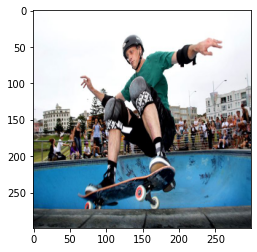

In [ ]:
plt.imshow(img)

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man is doing a trick on a skateboard .
a man is riding a skateboard down the street .
a man is doing a trick on a skateboard .
a man is riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down the street .


--2021-07-06 22:24:54--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-06 22:24:54--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   409KB/s    in 0.3s    

2021-07-06 22:24:55 (409 KB/s) - ‘img.jpg’ saved [106870/106870]



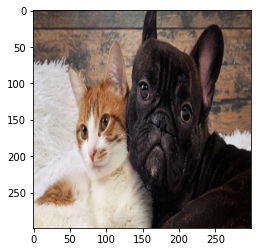

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a cat is sitting on a chair with a book .
a cat laying on top of a wooden table .
a cat is sitting on a bed with a book .
a cat laying on top of a wooden table .
a cat sitting on a chair next to a book .
a cat is laying on a chair next to a window .
a cat laying on top of a bed .
a cat laying on top of a bed .
a cat is sitting on a couch next to a book .
a cat laying on top of a bed .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2021-07-07 15:50:59--  https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg
Resolving legkovmeste.ru (legkovmeste.ru)... 116.202.193.218
Connecting to legkovmeste.ru (legkovmeste.ru)|116.202.193.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104424 (102K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 101.98K   196KB/s    in 0.5s    

2021-07-07 15:51:01 (196 KB/s) - ‘img.jpg’ saved [104424/104424]



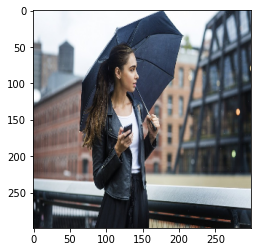

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a woman holding a umbrella in front of a building .
a woman holding a umbrella while standing on a sidewalk .
a woman holding a cell phone to a woman .
a woman holding a umbrella in front of a building .
a woman is holding a umbrella in front of a building .
a woman standing next to a woman holding a cell phone .
a woman holding a umbrella in front of a building .
a woman holding a phone in front of a building .
a woman is holding a cell phone in front of a building .
a woman is holding a umbrella in front of a building .


In [20]:
!wget https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 15:47:41--  https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg
Resolving 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)... 108.161.188.228
Connecting to 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)|108.161.188.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61211 (60K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  59.78K  --.-KB/s    in 0.1s    

2021-07-07 15:47:42 (472 KB/s) - ‘img.jpg’ saved [61211/61211]



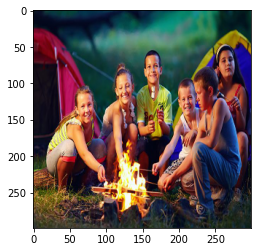

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a man is sitting on a bench with a laptop .
a man sitting on a bench with a laptop .
a man sitting on a bench with a dog .
a man sitting on a bench with a laptop .
a man is sitting on a bench in front of a laptop .
a man sitting on a bench with a laptop .
a man sitting on a bench with a laptop .
a group of people sitting on a bench .
a man sitting on a bench in front of a wooden table .
a group of people sitting around a table .


In [19]:
!wget https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.

Чтобы attention работал лучше и давал улучшения описаний картинок, необходимо немного иначе предобработать изходный датасет, а именно сделать так, чтобы каждый элемент из 2048 вектора картинки имел больше фичей. Пример необходимой предобработки для сетки InceptionV3 можно увидеть в этом [скрипте](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b). 

Так как исходный датасет слишком большой и его предобработка требует GPU, RAM, которых недостаточно на моей машине, colab или kaggle. То приведённая здесь реализация Attention тестировалась на предоставленном предобработанном датасете.

In [21]:
class BahdanauAttention(nn.Module):
    """ Class performs Additive Bahdanau Attention.
        Source: https://arxiv.org/pdf/1409.0473.pdf
     
    """    
    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # fully-connected layer to learn first weight matrix Wa
        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        # fully-connected layer to learn the second weight matrix Ua
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        # fully-connected layer to produce score (output), learning weight matrix va
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)
                
    def forward(self, features, decoder_hidden):
        """
        Arguments:
        ----------
        - features - features returned from Encoder
        - decoder_hidden - hidden state output from Decoder
                
        Returns:
        ---------
        - context - context vector with a size of (1,2048)
        - atten_weight - probabilities, express the feature relevance
        """
        # add additional dimension to a hidden (required for summation)


        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        # apply tangent to combine result from 2 fc layers
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        # first, we will multiply each vector by its softmax score
        # next, we will sum up this vectors, producing the attention context vector
        # the size of context equals to a number of feature maps
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)
        
        return context, atten_weight

In [23]:
class DecoderRNN(nn.Module):
    """Attributes:
         - embedding_dim - specified size of embeddings;
         - hidden_dim - the size of RNN layer (number of hidden states)
         - vocab_size - size of vocabulary 
         - p - dropout probability
    """

    def __init__(self, n_tokens, embedding_dim=128, hidden_dim=256, num_features=2048, p=0.5):

        super(DecoderRNN, self).__init__()

        self.num_features = num_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_tokens = n_tokens
        # scale the inputs to softmax
        self.sample_temp = 0.5

        # embedding layer that turns words into a vector of a specified size
        self.embeddings = nn.Embedding(n_tokens, embedding_dim)
        # LSTM will have a single layer of size 512 (512 hidden units)
        # it will input concatinated context vector (produced by attention) 
        # and corresponding hidden state of Decoder
        self.lstm = nn.LSTMCell(embedding_dim + num_features, hidden_dim)
        # produce the final output
        self.fc = nn.Linear(hidden_dim, n_tokens)

        # add attention layer 
        self.attention = BahdanauAttention(num_features, hidden_dim)
        # dropout layer
        self.drop = nn.Dropout(p=p)
        # add initialization fully-connected layers
        # initialize hidden state and cell memory using average feature vector 
        # Source: https://arxiv.org/pdf/1502.03044.pdf
        self.init_h = nn.Linear(num_features, hidden_dim)
        self.init_c = nn.Linear(num_features, hidden_dim)

    def forward(self, features, captions, sample_prob=0.0):

        """
        Arguments
        ----------
        - captions - image captions
        - features - features returned from Encoder
        - sample_prob - use it for scheduled sampling

        Returns
        ----------
        - outputs - output logits from t steps
        - atten_weights - weights from attention network
        """
        # create embeddings for captions of size (batch, sqe_len, embed_dim)
        features = features.unsqueeze(1)
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = captions.size(1)
        feature_size = features.size(1)
        batch_size = features.size(0)
        # these tensors will store the outputs from lstm cell and attention weights
        outputs = torch.zeros(batch_size, seq_len, self.n_tokens)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size)
    
        # scheduled sampling for training
        # we do not use it at the first timestep (<start> word)
        # but later we check if the probability is bigger than random
        for t in range(seq_len):
            sample_prob = 0.0 if t == 0 else 0.5
            use_sampling = np.random.random() < sample_prob
            if use_sampling == False:
                word_embed = embed[:, t, :]
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)

            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h, c))
            h = self.drop(h)
            output = self.fc(h)
            if use_sampling == True:
                # use sampling temperature to amplify the values before applying softmax
                scaled_output = output / self.sample_temp
                scoring = F.log_softmax(scaled_output, dim=1)
                top_idx = scoring.topk(1)[1]
                word_embed = self.embeddings(top_idx).squeeze(1)
            outputs[:, t, :] = output

            atten_weights[:, t, :] = atten_weight
        return outputs


    def init_hidden(self, features):
        """Initializes hidden state and cell memory using average feature vector.
        Arguments:
        ----------
        - features - features returned from Encoder
    
        Retruns:
        ----------
        - h0 - initial hidden state (short-term memory)
        - c0 - initial cell state (long-term memory)
        """
        mean_annotations = torch.mean(features, dim=1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0

In [ ]:
network = DecoderRNN(n_tokens)

In [ ]:
optimizer = torch.optim.Adam(network.parameters()) # favourite one
criterion = nn.CrossEntropyLoss(ignore_index = pad_ix)

In [ ]:
from tqdm.notebook import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, criterion, *generate_batch(train_img_codes, train_captions, batch_size))
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.data.numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, criterion, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 5.991792459487915, val loss: 5.0795595169067385


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.207188682556152, val loss: 5.04741325378418


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 5.107357969284058, val loss: 4.953965187072754


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 5.007682371139526, val loss: 4.891815280914306


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.954071388244629, val loss: 4.834616470336914


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.931132040023804, val loss: 4.833179569244384


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.820029144287109, val loss: 4.650469207763672


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.775583391189575, val loss: 4.648736095428466


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.7140709400177006, val loss: 4.525371837615967


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.708305311203003, val loss: 4.413649082183838


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.617159996032715, val loss: 4.436514186859131


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.5931721019744876, val loss: 4.460410499572754


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.560683088302612, val loss: 4.414015102386474


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 4.528371000289917, val loss: 4.406506156921386


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.514627857208252, val loss: 4.388900661468506


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 4.506620388031006, val loss: 4.2915020942687985


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 4.459493837356567, val loss: 4.4117766380310055


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 4.432368059158325, val loss: 4.251528739929199


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 4.414275093078613, val loss: 4.3003276824951175


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 4.3748152685165405, val loss: 4.182086944580078


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 4.427072033882141, val loss: 4.245867538452148


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 4.381208477020263, val loss: 4.182623338699341


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 4.398192949295044, val loss: 4.289523029327393


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 4.373048071861267, val loss: 4.111392974853516


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 4.34597225189209, val loss: 4.098337888717651


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 4.272025651931763, val loss: 4.082712030410766


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 4.321593208312988, val loss: 4.1160839080810545


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 4.275180759429932, val loss: 4.250848960876465


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 4.304068102836609, val loss: 4.111874151229858


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 4.213824129104614, val loss: 4.132107543945312


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 4.281502075195313, val loss: 4.039105939865112


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 4.270960283279419, val loss: 4.122352981567383


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 4.164170455932617, val loss: 3.98193244934082


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 4.25100302696228, val loss: 3.9962407112121583


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 4.204304370880127, val loss: 4.048121118545533


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 4.183096323013306, val loss: 4.039053153991699


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 4.200913867950439, val loss: 3.9972331047058107


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 4.214707369804382, val loss: 3.8360804080963136


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 4.146981210708618, val loss: 4.0440326690673825


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 4.255696792602539, val loss: 3.9941507816314696


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 4.1518858051300045, val loss: 3.866765546798706


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 4.2211912250518795, val loss: 3.8966086387634276


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 4.165722036361695, val loss: 3.950178623199463


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 4.125747780799866, val loss: 3.98169150352478


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 4.143725357055664, val loss: 3.906666612625122


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 4.121777658462524, val loss: 3.9723058223724363


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 4.145740084648132, val loss: 3.8320950984954836


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 4.19167724609375, val loss: 3.813385772705078


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 4.105733761787414, val loss: 3.882727861404419


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 4.06999550819397, val loss: 3.956964874267578


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 4.095291213989258, val loss: 4.089788579940796


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 4.121100993156433, val loss: 4.0303644180297855


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 4.123188400268555, val loss: 3.79767427444458


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 4.061313228607178, val loss: 3.926684761047363


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 4.050079011917115, val loss: 4.071429634094239


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 4.1583553981781005, val loss: 3.8884997367858887


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 4.100046768188476, val loss: 3.811678647994995


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 4.125117416381836, val loss: 3.8251180171966555


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 4.099095315933227, val loss: 3.963990306854248


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 4.124121747016907, val loss: 3.892241907119751


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 4.071712141036987, val loss: 3.851756525039673


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 4.067821354866028, val loss: 3.8694365978240968


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 4.046702103614807, val loss: 3.9267614841461183


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 4.071209192276001, val loss: 3.885684108734131


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 4.072786107063293, val loss: 3.9111201763153076


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 4.017805609703064, val loss: 3.9816033363342287


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 4.055273141860962, val loss: 3.8111797332763673


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 4.121116623878479, val loss: 3.856220531463623


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 4.026337451934815, val loss: 3.721269369125366


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 4.101726298332214, val loss: 3.8932472229003907


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 4.0424625062942505, val loss: 3.8161409378051756


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 4.045593614578247, val loss: 3.7353796482086183


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 4.08300703048706, val loss: 3.7811668872833253


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 4.028563690185547, val loss: 3.884108304977417


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 4.05441659450531, val loss: 3.860804891586304


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 4.002471227645874, val loss: 3.758134365081787


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 4.02286208152771, val loss: 3.814969301223755


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 4.039240546226502, val loss: 3.7988494873046874


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 4.058974986076355, val loss: 3.6719082832336425


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 4.018717684745789, val loss: 3.7532182216644285


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 3.9822877550125124, val loss: 3.6501861572265626


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 3.987972936630249, val loss: 3.641576337814331


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 3.981644458770752, val loss: 3.8353154182434084


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 4.006034212112427, val loss: 3.815212535858154


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 3.9783383798599243, val loss: 3.797021818161011


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 4.036303482055664, val loss: 3.806738519668579


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 3.980842909812927, val loss: 3.590265893936157


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 3.9312734603881836, val loss: 3.7195412158966064


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 3.9728907537460327, val loss: 3.801986074447632


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 3.960941343307495, val loss: 3.7060694217681887


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 3.9500579929351805, val loss: 3.6960310459136965


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 4.003141570091247, val loss: 3.829613542556763


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 4.046609058380127, val loss: 3.9331172466278077


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 3.94569785118103, val loss: 3.7475471019744875


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 4.023741612434387, val loss: 3.7965588569641113


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 3.9198185634613036, val loss: 3.8238622665405275


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 3.948458399772644, val loss: 3.7414856910705567


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 3.9646217823028564, val loss: 3.6992098331451415


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 3.9764791679382325, val loss: 3.6778976917266846


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 99, train loss: 4.002371435165405, val loss: 3.8979182720184324
Finished!


In [ ]:
with bz2.open('caption_net_attn.pkl.bz2', 'wb') as f:
    pickle.dump(network, f, protocol=4)

In [24]:
with bz2.open('caption_net_attn.pkl.bz2', 'rb') as f:
    network = pickle.load(f)

--2021-07-07 00:47:18--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.200.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.200.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-07 00:47:18--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.202.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.202.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.08s   

2021-07-07 00:47:19 (632 KB/s) - ‘img.jpg’ saved [54731/54731]



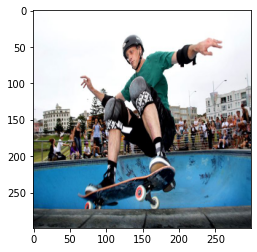

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a man riding doing skateboard on in a skateboard .
a man is a a trick a a skateboard .
a man riding a skateboard in a air skateboard
a man is a skateboard a a skateboard .
a man is a skateboard skateboard a skateboard skateboard .
a man is a a on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man is riding a trick skateboard a skateboard .
a man is a skateboard the on skateboard .


In [ ]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 00:47:34--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-07 00:47:34--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   407KB/s    in 0.3s    

2021-07-07 00:47:35 (407 KB/s) - ‘img.jpg’ saved [106870/106870]



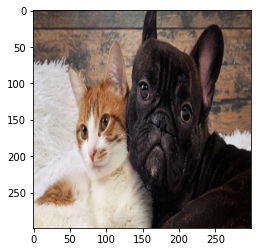

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a cat cat on on a of with .
a cat cat laying on a a of a . .
a cat laying on a a of a cat .
a cat is laying on a a with a
a cat is laying on a a a . .
a cat is laying on a a of .
a cat laying is a bed on a a .
a cat laying laying on a a of a a .
a cat laying on a a with with a .
a cat is laying on a a and a a .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 15:53:36--  https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg
Resolving legkovmeste.ru (legkovmeste.ru)... 116.202.193.218
Connecting to legkovmeste.ru (legkovmeste.ru)|116.202.193.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104424 (102K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 101.98K   194KB/s    in 0.5s    

2021-07-07 15:53:38 (194 KB/s) - ‘img.jpg’ saved [104424/104424]



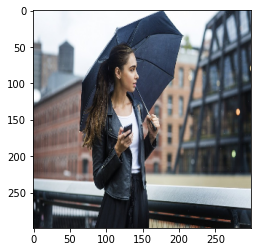

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a woman holding a umbrella on a umbrella umbrella .
a man of a a umbrella a a umbrella .
a man is a a umbrella a umbrella .
a woman is a a umbrella umbrella with
a woman holding a umbrella of a umbrella .
a man of a umbrella on with sidewalk .
a man is a umbrella on a umbrella a
a man is a a a a a umbrella . .
a woman holding a a down a umbrella umbrella
a woman is a a umbrella with umbrella umbrella


In [25]:
!wget https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 15:54:18--  https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg
Resolving 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)... 108.161.188.228
Connecting to 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)|108.161.188.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61211 (60K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  59.78K  --.-KB/s    in 0.1s    

2021-07-07 15:54:19 (472 KB/s) - ‘img.jpg’ saved [61211/61211]



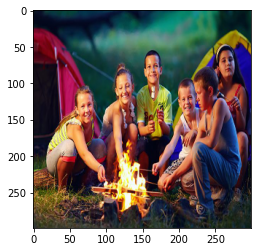

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a group of people people around a a .
a group is people around a a table with a a
a man is sitting a a a of a a .
a group of people people in a table .
a man sitting a a of a a a .
a group of a a on a table a
a group of people are sitting on a table .
a man in a a with a a a .
a man is a in a a with a .
a group is people are standing in a table .


In [27]:
!wget https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Flickr8 Dataset instead of MSCOCO

Решение было также протестировано с датасетом Flickr8k. Описания получились несколько хуже, так как сам датасет гораздо меньше, что возможно повлияло на качество обучения.

In [ ]:
import numpy as np
import json

# загружаем датасет
#img_codes = np.load("gdrive/My Drive/data/image_codes.npy")
#captions = json.load(open('gdrive/My Drive/data/captions_tokenized.json'))
img_codes = np.load("/kaggle/input/flickr8-ds/image_codes.npy")
with open('/kaggle/input/flickr8-ds/texts.txt') as f:
    texts = f.read()
captions = list(filter(None, [list(filter(None, [caption_img for caption_img in captions.split('\t')])) for captions in texts.split('\n')]))

In [ ]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (8091, 2048) ]
[0.16701008 0.11178281 1.029347   0.2678434  0.432042   0.15891711
 0.17089659 0.6170226  0.28932214 0.26636913]

For each image there are 5 reference captions, e.g.:

a child in a pink dress is climbing up a set of stairs in an entry way .
a girl going into a wooden building .
a little girl climbing into a wooden playhouse .
a little girl climbing the stairs to her playhouse .
a little girl in a pink dress going into a wooden cabin .


In [ ]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [ ]:
print(len(captions))

8091


In [ ]:
# Build a Vocabulary
from collections import Counter

word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for caption_imj in captions:
    for sentence in caption_imj:
        word_counts.update(sentence)



In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
with bz2.open('vocab_flickr8.pkl.bz2', 'wb') as f:
    pickle.dump(vocab, f, protocol=4)

In [ ]:
with bz2.open('word_to_index_flickr8.pkl.bz2', 'wb') as f:
    pickle.dump(word_to_index, f, protocol=4)

In [28]:
with bz2.open('vocab_flickr8.pkl.bz2', 'rb') as f:
    vocab = pickle.load(f)

In [29]:
with bz2.open('word_to_index_flickr8.pkl.bz2', 'rb') as f:
    word_to_index = pickle.load(f)

In [30]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
optimizer = torch.optim.Adam(network.parameters()) # favourite one
criterion = nn.CrossEntropyLoss(ignore_index = pad_ix)

In [ ]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
batch_size = 50  
n_epochs = 100  
n_batches_per_epoch = 50  
n_validation_batches = 5  

In [ ]:
from tqdm.notebook import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, criterion, *generate_batch(train_img_codes, train_captions, batch_size))
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.data.numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, criterion, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")



  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 5.400371789932251, val loss: 4.508232879638672


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 4.30903434753418, val loss: 4.054056310653687


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.0275869989395146, val loss: 3.7786895275115966


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 3.8145323276519774, val loss: 3.7092858791351317


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 3.667981071472168, val loss: 3.6283166885375975


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 3.535251274108887, val loss: 3.571115827560425


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.464792399406433, val loss: 3.506595754623413


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.37486711025238, val loss: 3.328503894805908


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.30860493183136, val loss: 3.430995750427246


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.3026565217971804, val loss: 3.240974521636963


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.2331296682357786, val loss: 3.140005350112915


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.170259566307068, val loss: 3.160476303100586


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.128024110794067, val loss: 3.1267395496368406


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.105940556526184, val loss: 3.177208995819092


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.0466613006591796, val loss: 3.1085967063903808


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.0274445819854736, val loss: 3.0281639099121094


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.015906753540039, val loss: 3.137195920944214


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 2.95887770652771, val loss: 3.0690863132476807


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 2.9329535150527954, val loss: 2.9877049922943115


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 2.8916239833831785, val loss: 2.9707541942596434


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 2.879771547317505, val loss: 2.8850022315979005


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 2.8857812595367434, val loss: 2.9916998386383056


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 2.843403697013855, val loss: 2.933277988433838


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 2.8076833724975585, val loss: 2.958340072631836


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 2.7830934429168703, val loss: 2.9405558586120604


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 2.7784541988372804, val loss: 2.935438346862793


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 2.767299885749817, val loss: 2.8646448135375975


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 2.738333330154419, val loss: 2.88762845993042


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 2.726897201538086, val loss: 2.831482696533203


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 2.6793261337280274, val loss: 2.909382772445679


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.69554639339447, val loss: 2.914059209823608


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 2.6927422666549683, val loss: 2.8330076217651365


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.6685822200775147, val loss: 2.796376609802246


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 2.678587546348572, val loss: 2.7925346374511717


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.635852961540222, val loss: 2.7954423427581787


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 2.6571606636047362, val loss: 2.798675775527954


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.612978024482727, val loss: 2.8717343330383303


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.5688486528396606, val loss: 2.9242714405059815


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.5797886657714844, val loss: 2.7382309436798096


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 2.6056013822555544, val loss: 2.7917255401611327


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.5731127977371218, val loss: 2.9170773029327393


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.5488530349731446, val loss: 2.7312148571014405


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.503906307220459, val loss: 2.7753766536712647


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.514588785171509, val loss: 2.7867117881774903


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.489833836555481, val loss: 2.767705965042114


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.523457336425781, val loss: 2.761447525024414


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.508439688682556, val loss: 2.691220235824585


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.4910213804244994, val loss: 2.7653063774108886


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.4625518417358396, val loss: 2.75550217628479


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 2.472794952392578, val loss: 2.8008206367492674


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.478656392097473, val loss: 2.711589479446411


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.467040719985962, val loss: 2.7736218929290772


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.4376216411590574, val loss: 2.741273355484009


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.410519337654114, val loss: 2.715076541900635


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.4216870212554933, val loss: 2.757970094680786


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.388975672721863, val loss: 2.6649155616760254


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.4188128328323364, val loss: 2.772629404067993


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.3958012151718138, val loss: 2.7118342399597166


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.39179639339447, val loss: 2.7635661125183106


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.385701017379761, val loss: 2.591436004638672


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.384194869995117, val loss: 2.748602056503296


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.389580206871033, val loss: 2.67031192779541


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.3993159675598146, val loss: 2.762289571762085


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.337203035354614, val loss: 2.793254280090332


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.357238574028015, val loss: 2.7683174133300783


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.347094078063965, val loss: 2.765419435501099


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.339668288230896, val loss: 2.6191452980041503


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.3265219926834106, val loss: 2.784947633743286


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.3364782619476316, val loss: 2.7132340908050536


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.2676578521728517, val loss: 2.8136362075805663


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.3148426961898805, val loss: 2.7315381526947022


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.3204410219192506, val loss: 2.6542193412780763


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.290446171760559, val loss: 2.738826274871826


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.2980159854888917, val loss: 2.7659185409545897


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.298061580657959, val loss: 2.658782196044922


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.262665657997131, val loss: 2.7004305839538576


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.2545700883865356, val loss: 2.6398215293884277


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.2431907176971437, val loss: 2.6485316276550295


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.232601752281189, val loss: 2.6232751846313476


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.2486082458496095, val loss: 2.7067287445068358


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.248730320930481, val loss: 2.7393189907073974


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.2266716289520265, val loss: 2.67566294670105


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.238422589302063, val loss: 2.627579593658447


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.204904818534851, val loss: 2.7214361667633056


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.206514525413513, val loss: 2.738014316558838


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.1915632700920105, val loss: 2.678982448577881


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.229389171600342, val loss: 2.667452812194824


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.2132725429534914, val loss: 2.742407703399658


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.184307885169983, val loss: 2.717989778518677


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.1874728298187254, val loss: 2.680546426773071


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.170925521850586, val loss: 2.7153305053710937


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.171569139957428, val loss: 2.726227951049805


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.1747287631034853, val loss: 2.702207088470459


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.144986717700958, val loss: 2.6128580570220947


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.1600461411476135, val loss: 2.708402681350708


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.167649812698364, val loss: 2.722893762588501


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.1230203247070314, val loss: 2.59737606048584


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.1269421982765198, val loss: 2.6215782165527344


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.1406101059913634, val loss: 2.656658887863159


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 99, train loss: 2.117921326160431, val loss: 2.736092233657837
Finished!


In [ ]:
with bz2.open('caption_net_flickr8.pkl.bz2', 'wb') as f:
    pickle.dump(network, f, protocol=4)

In [31]:
with bz2.open('caption_net_flickr8.pkl.bz2', 'rb') as f:
    network = pickle.load(f)

In [ ]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

--2021-07-07 04:39:38--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.248.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.248.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-07 04:39:38--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.250.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.250.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.06s   

2021-07-07 04:39:39 (859 KB/s) - ‘img.jpg’ saved [54731/54731]



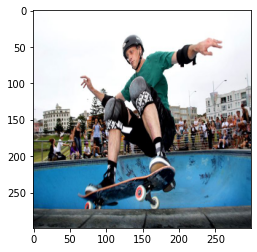

In [ ]:
plt.imshow(img)

In [ ]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a skateboarder jumps high in the air .
a skateboarder doing a trick on a ramp .
a skateboarder does a trick on a ramp .
a skateboarder in a red shirt and a white shirt is performing a trick .
a man jumping a trick on a skateboard in the air .
a skateboarder jumps over a ramp .
a skateboarder jumps over a ramp .
a man in a white shirt and blue shorts jumps in a parking lot .
a skateboarder performs a trick in the air .
a skateboarder jumps over a ramp .


--2021-07-07 04:39:42--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-07 04:39:43--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   552KB/s    in 0.2s    

2021-07-07 04:39:43 (552 KB/s) - ‘img.jpg’ saved [106870/106870]



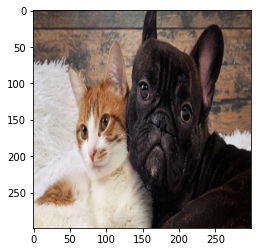

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a black dog with a blue shirt and blue eyes is standing next to a brown dog .
a black dog with a blue collar is looking at the camera .
a small black dog is standing on its hind legs .
a black dog is standing on its hind legs .
a black dog with a red bandanna is standing next to a brown dog .
a brown dog is biting a camera .
a black dog and a brown dog are playing with a ball in its mouth .
a black dog is standing on its hind legs .
a brown dog is biting a camera .
a black dog is licking its nose .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 15:56:27--  https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg
Resolving legkovmeste.ru (legkovmeste.ru)... 116.202.193.218
Connecting to legkovmeste.ru (legkovmeste.ru)|116.202.193.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104424 (102K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 101.98K   195KB/s    in 0.5s    

2021-07-07 15:56:30 (195 KB/s) - ‘img.jpg’ saved [104424/104424]



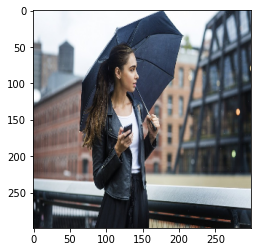

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a man in a black jacket and a woman in a black shirt .
a man in a black jacket is standing in front of a crowd of people .
a man in a green shirt and tie is standing in front of a crowd of people .
a man in a black jacket is standing in front of a crowd of people .
a man in a black jacket and a black jacket is standing in front of a crowd .
a man in a black jacket is standing in front of a crowd of people .
a man in a black jacket is standing in front of a crowd of people .
a man in a black jacket and a woman in a black shirt .
a man in a black jacket is standing in front of a crowd of people .
a man in a black jacket is standing in front of a crowd of people .


In [32]:
!wget https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 15:56:48--  https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg
Resolving 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)... 108.161.188.228
Connecting to 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)|108.161.188.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61211 (60K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  59.78K  --.-KB/s    in 0.1s    

2021-07-07 15:56:49 (472 KB/s) - ‘img.jpg’ saved [61211/61211]



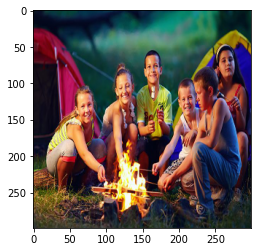

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a man and a woman are sitting in a crowd of people .
a group of people are sitting at a table in the park .
a man and a woman are playing a guitar .
a group of people in a crowd of people .
a man and a woman are playing a guitar .
a group of people are sitting in a crowd of people .
a man and a woman are playing a guitar .
a man and a woman are playing a guitar .
a group of people are sitting in a line of #UNK# .
a man and a woman are sitting in a crowd of people .


In [33]:
!wget https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

## Flickr8 with Attention

In [ ]:
network = DecoderRNN(n_tokens)

In [ ]:
optimizer = torch.optim.Adam(network.parameters()) # favourite one
criterion = nn.CrossEntropyLoss(ignore_index = pad_ix)

In [ ]:
from tqdm.notebook import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, criterion, *generate_batch(train_img_codes, train_captions, batch_size))
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.data.numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, criterion, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")



  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
with bz2.open('caption_net_attn_flickr8.pkl.bz2', 'wb') as f:
    pickle.dump(network, f, protocol=4)

In [34]:
with bz2.open('caption_net_attn_flickr8.pkl.bz2', 'rb') as f:
    network = pickle.load(f)

--2021-07-07 05:29:33--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.248.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.248.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-07 05:29:34--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.250.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.250.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.06s   

2021-07-07 05:29:34 (860 KB/s) - ‘img.jpg’ saved [54731/54731]



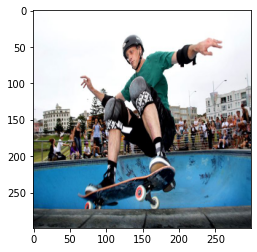

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a man in a shorts is jumping a a a .
a boy is jumping a a a
a boy in a a on a a . .
a boy is doing a a . trick skateboard . .
a man in a a shirt on jumping a a . .
a man in a air . a a .
a man is a a trick on a skateboard .
a boy in a trick on a skateboard . a a
a man in a trick shirt a a skateboard
a man in a a trick a the .


In [ ]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 05:29:38--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-07 05:29:39--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   553KB/s    in 0.2s    

2021-07-07 05:29:39 (553 KB/s) - ‘img.jpg’ saved [106870/106870]



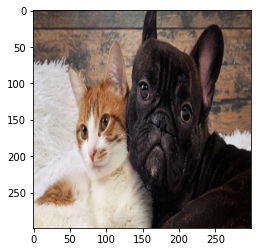

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


a black dog is a a a .
a black dog and white dog is a in a
a black dog and a white a .
a black dog is a a a .
a black dog is white on a .
a black dog and dog is a a a .
a black dog is a a with . #UNK# .
a black dog is a a a a .
a black dog is a a a . .
a black dog white a is a . is


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 15:58:22--  https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg
Resolving legkovmeste.ru (legkovmeste.ru)... 116.202.193.218
Connecting to legkovmeste.ru (legkovmeste.ru)|116.202.193.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104424 (102K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 101.98K   197KB/s    in 0.5s    

2021-07-07 15:58:24 (197 KB/s) - ‘img.jpg’ saved [104424/104424]



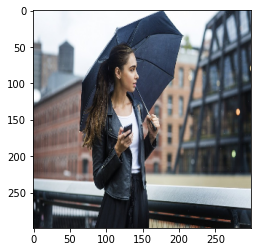

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a man in a a jacket is walking on a sidewalk .
a man in a red jacket is is a a
a woman in a red shirt and is a a a
a man in a a shirt is a a .
a man in a black shirt is a a a
a man in a red jacket jacket a a a and a . .
a man in a blue jacket is a a a . .
a woman in a black shirt is a a in .
a man in a blue jacket and a white and a a . .
a man in a red shirt and a a #UNK# a


In [35]:
!wget https://legkovmeste.ru/wp-content/uploads/2019/11/post_5dbefdb6e71f1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2021-07-07 15:58:35--  https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg
Resolving 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)... 108.161.188.228
Connecting to 3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com (3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com)|108.161.188.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61211 (60K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  59.78K  --.-KB/s    in 0.1s    

2021-07-07 15:58:35 (471 KB/s) - ‘img.jpg’ saved [61211/61211]



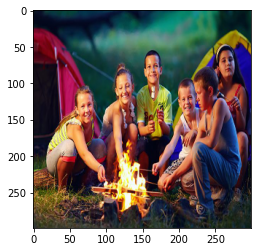

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


a group in people are sitting on a a .
a group of people are a a in a
a group of people are are in a . .
a group of of people are in a the .
a group of people are in a a . .
a group of people people are in on a .
a group of people people are in a . .
a group of people are are in a a .
a group of people people in a a .
a group in people of #UNK# the #UNK# .


In [36]:
!wget https://3dq1fq1lesjd1aw5045f5a6h-wpengine.netdna-ssl.com/wp-content/uploads/2014/06/SR_CampingActivities.jpg -O img.jpg
img = plt.imread('img.jpg')
img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Применение другой CNN модели вместо InceptionV3

Чтобы применить другую CNN модель, необходимо иметь иной предобработанный датасет. Вектора картинок image_codes.npy должны являться не выходом InceptionV3, а уже другой модели, которую мы хотим использовать вместо InceptionV3, например ResNet152. 

Как уже было описано выше, предобработка исходного датасета требует больших объемов памяти и вычислительных мощностей.

Ниже привожу пример как должен выглядеть Encoder CNN сети при использовании ResNet152 вместо InceptionV3

In [ ]:
class EncoderCNN(nn.Module):
    """Encoder inputs images and returns feature maps.
    Aruments:
    ---------
    - image - augmented image sample
    
    Returns:
    ---------
    - features - feature maps of size (batch, height*width, #feature maps)
    """
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        # first, we need to resize the tensor to be 
        # (batch, size*size, feature_maps)
        batch, feature_maps, size_1, size_2 = features.size()       
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)
       
        return features